### Imports

In [131]:
import numpy as np
import os
from numpy.fft import fft2, ifft2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter

### Functions

In [173]:
# start_top = 612
margin = 5

def crop_letters(filepath, start_left, start_top, width, height, lines, in_line):
    image = Image.open(filepath)
    
    
    for i in range(lines):
        for j in range(in_line):
            top = start_top + int(i * height)
            left = start_left + int(j * width)
            
            curr_width = int(width)
            
            letter = image.crop((left, top, left+curr_width, top+height))
            
            with open(f"ocr/letters/{i*in_line + j}.jpg", "w+"):
                pass
            
            letter.save(f"ocr/letters/{i*in_line + j}.jpg")

#     return np.array(letter)
    
def show_image(image):
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

#     ax.imshow(image, cmap='gray')
    ax.imshow(image)
    
    plt.show()
    
    
class Point:
    def __init__(self, coords, character, correlation):
        self._coords = coords
        self._character = character
        self._correlation = correlation
        
    def __lt__(self, other):
        if abs(self.coords[1] - other.coords[1]) > 2 * margin:
            return True if self.coords[1] < other.coords[1] else False
        else:
            return True if self.coords[0] < other.coords[0] else False
        
    def __eq__(self, other):
        if type(self) == type(other) and \
        abs(self.coords[0] - other.coords[0]) <= 2 * margin and \
        abs(self.coords[1] - other.coords[1]) <= 2 * margin:
            return True
        
        return False
        
    
    def __hash__(self):
        return hash(self._coords)
    
    @property
    def coords(self):
        return self._coords
    
    @property
    def character(self):
        return self._character
    
    @property
    def correlation(self):
        return self._correlation
    

def get_patterns(text_type):
    return os.listdir(f"ocr/{text_type}")
#     return ["..jpg"]
    
    
def get_array(filename, original=False, invert=True):
    image = Image.open(filename)
    
    if not original:
        image = image.convert("L")
        if invert:
            image = PIL.ImageOps.invert(image)

    return np.array(image)


def get_angle_score(image, angle):
    rotated = inter.rotate(image, angle, reshape=False, order=0)
    hist = np.sum(rotated, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score


def deskew(image):
    delta = 0.2
    limit = 5
    angles = np.arange(-limit, limit, delta)
    angles = list(map(lambda x: round(x, 1), angles))

    scores = []
    for angle in angles:
        hist, score = get_angle_score(image, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]

    # correct skew
    image = inter.rotate(image, best_angle, reshape=False, order=0)
    print(best_angle)
    
    return image
    

def get_possible_rows(start_top, height, lines):
    rows = set()
    
    for i in range(1, lines+1):
        rows |= set([x for x in range(
            start_top + int(i*height) - margin, start_top + int(i*height) + margin + 1)])
        
    return rows
    
    
def get_possible_columns(start_left, width, in_line):
    columns = set()
    
    for i in range(1, in_line+1):
        columns |= set([y for y in range(
            start_left + int(i*width) - margin, start_left + int(i*width) + margin + 1)])
        
    return columns


def get_occurrence(image, pattern, possible_rows, possible_columns, pattern_name, threshold):
    occurrence = np.real(ifft2(fft2(image) * fft2(np.rot90(pattern, 2), image.shape)))
    
    highlighted_points = []
    
    for i in range(occurrence.shape[0]):
        for j in range(occurrence.shape[1]):
            if occurrence[i, j] > threshold and i in possible_rows and j in possible_columns:
                highlighted_points.append(Point((j, i), pattern_name[0], occurrence[i, j]))

    return highlighted_points


def extract_characters(points, width):
    text = ""
    
    curr_best = points[0]
    
    for i in range(1, len(points)):
        if points[i-1] == points[i] and points[i].correlation > curr_best.correlation:
            curr_best = points[i]
        elif not points[i-1] == points[i]:
            text += curr_best.character
            curr_best = points[i]
            
            if points[i].coords[1] - points[i-1].coords[1] > 2 * margin:
                text += "\n"
            elif points[i].coords[0] - points[i-1].coords[0] > width:
                text += " "
    
    text += curr_best.character
    
    return text

    
def read_text(text_type, start_left, start_top, width, height, lines, in_line, threshold):
    image_array = get_array(f"ocr/{text_type}_skewed.jpg")
    image_array = deskew(image_array)
    
    possible_rows = get_possible_rows(start_top, height, lines)
    possible_columns = get_possible_columns(start_left, width, in_line)
    
    highlighted_points = []
    
    for pattern in get_patterns(text_type):
        print(pattern, end=" ")
        pattern_array = get_array(f"ocr/{text_type}/{pattern}")
        
        highlighted_points += get_occurrence(image_array, pattern_array, 
                                             possible_rows, possible_columns,
                                             pattern, threshold)

    highlighted_points.sort()
    text = extract_characters(highlighted_points, width)
#     print(highlighted_points.coords)
    
#     for i in range(len(highlighted_points)):
#         print(highlighted_points[i].coords)

    return text, highlighted_points

    
def separate_coordinates(points):
    points_x = list(map(lambda point: point.coords[0], points))
    points_y = list(map(lambda point: point.coords[1], points))

    return points_x, points_y


def show_image(image, points):
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    ax.imshow(image, cmap='gray')
    
    points_x, points_y = separate_coordinates(points)
    ax.scatter(points_x, points_y, c="#FF0000", s=5)
    
    plt.show()

    
def check_correctness(text):
    with open("ocr/text.txt", "r") as file:
        correct_text = file.read()
        
        correct_characters = 0
        
        for i in range(min(len(text), len(correct_text))):
            if text[i] == correct_text[i]:
                correct_characters += 1
                
        return 100 * correct_characters / len(correct_text)
    

### roboto mono

In [124]:
start_left = 202
start_top = 197
width = 23.3
height = 59
lines = 3
in_line = 53

In [64]:
# crop_letters("ocr/roboto_mono_test.jpg", start_left, start_top, width, height, lines, in_line)

# show_image(letter)

In [174]:
text, points = read_text("roboto_mono", start_left, start_top, width, height, lines, in_line, 1.35 * 10**6)
print("\n" + text)

-3.0
..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg y.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
pzppgg ggppmppgqqppppgp ppggggpppgp gqpgqpgpgp
pgpppp gpggg pqppgppp qgqg gqpxpgg gp qggg
pggppgg ggpgqpgpp gpqp pppggpgpp pppqpgppgpg qqq


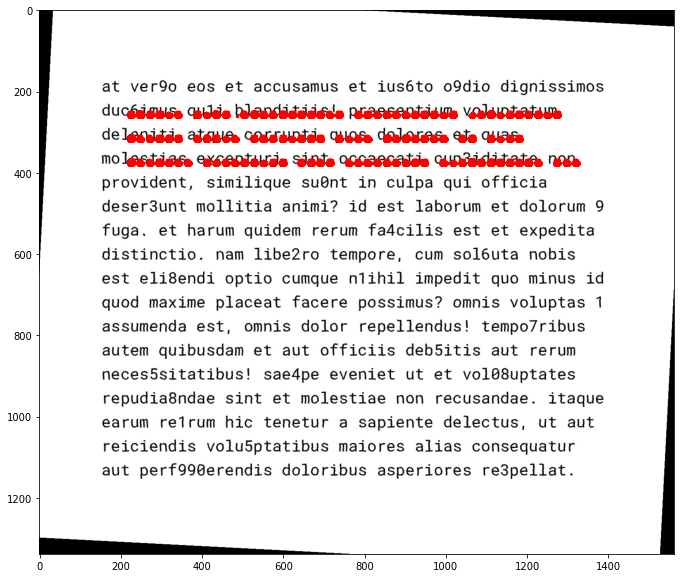

In [177]:
original_image = get_array(f"ocr/roboto_mono_skewed.jpg", original=True)
original_image = inter.rotate(original_image, -3, reshape=False, order=0)
# points = [Point((x, y), "", 0) for y in get_possible_rows(start_top, height, lines)
#           for x in get_possible_columns(start_left, width, in_line)]
show_image(original_image, points)
# deskew(original_image)

### courier new

In [21]:
start_left = 200
start_top = 197
width = 23.3
height = 50.8
lines = 17
in_line = 53

In [9]:
# crop_letters("ocr/roboto_mono_test.jpg", start_left, start_top, width, height, lies, in_line)

# show_image(letter)

In [22]:
text, points = read_text("courier_new", start_left, start_top, width, height, lines, in_line, 1.4 * 10**6)
print("\n" + text)

..jpg z.jpg b.jpg 9.jpg j.jpg !.jpg 1.jpg 7.jpg 0.jpg i.jpg s.jpg 2.jpg u.jpg c.jpg 8.jpg a.jpg d.jpg ?.jpg m.jpg ,.jpg v.jpg o.jpg 3.jpg 4.jpg g.jpg w.jpg q.jpg 6.jpg t.jpg n.jpg h.jpg k.jpg l.jpg x.jpg f.jpg p.jpg r.jpg e.jpg 5.jpg 
at ver9o eos et accusamus et ius6to o9dio dignissimos
duc6imus qu1i blanditiis! praesentium voluptatum
deleniti atque corrupti quos dolores et quas


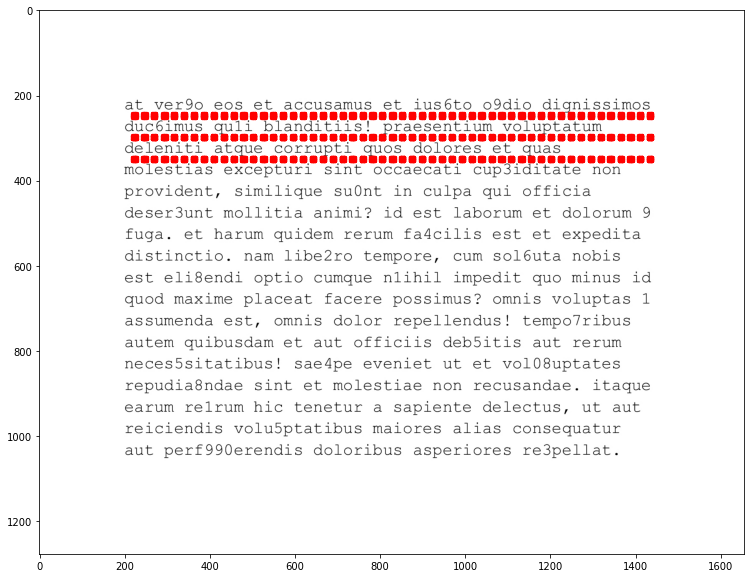

In [24]:
original_image = get_array(f"ocr/courier_new.jpg", original=True)
points = [Point((x, y), "", 0) for y in get_possible_rows() for x in get_possible_columns()]
show_image(original_image, points)

In [132]:
rate = check_correctness(text)
rate

99.42922374429224

In [58]:
a = set([2,3])
a |= {2,4, 3}
a

{2, 3, 4}

In [68]:
get_possible_rows()

[346, 347, 348, 349, 350, 351, 352, 353, 295, 296, 297, 298, 299, 300, 301, 302, 244, 245, 246, 247, 248, 249, 250, 251]


In [69]:
get_possible_columns()

[1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1244, 1245, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 219, 220, 221, 222, 223, 224, 225, 226, 1248, 1249, 1250, 1251, 1246, 1247, 242, 243, 244, 245, 246, 247, 248, 249, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 265, 266, 267, 268, 269, 270, 271, 272, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 289, 290, 291, 292, 293, 294, 295, 296, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 312, 313, 314, 315, 316, 317, 318, 319, 1344, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 335, 336, 337, 338, 339, 340, 341, 342, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 359, 360, 361, 362, 363, 364, 365, 366,

In [13]:
[(x, y) for x in get_possible_rows() for y in get_possible_columns()]

[(344, 1033),
 (344, 1034),
 (344, 1035),
 (344, 1036),
 (344, 1037),
 (344, 1038),
 (344, 1039),
 (344, 1040),
 (344, 1041),
 (344, 1042),
 (344, 1043),
 (344, 1429),
 (344, 1057),
 (344, 1058),
 (344, 1059),
 (344, 1060),
 (344, 1061),
 (344, 1062),
 (344, 1063),
 (344, 1064),
 (344, 1065),
 (344, 1066),
 (344, 1067),
 (344, 1080),
 (344, 1081),
 (344, 1082),
 (344, 1083),
 (344, 1084),
 (344, 1085),
 (344, 1086),
 (344, 1087),
 (344, 1088),
 (344, 1089),
 (344, 1090),
 (344, 1103),
 (344, 1104),
 (344, 1105),
 (344, 1106),
 (344, 1107),
 (344, 1108),
 (344, 1109),
 (344, 1110),
 (344, 1111),
 (344, 1112),
 (344, 1113),
 (344, 1127),
 (344, 1128),
 (344, 1129),
 (344, 1130),
 (344, 1131),
 (344, 1132),
 (344, 1133),
 (344, 1134),
 (344, 1135),
 (344, 1136),
 (344, 1137),
 (344, 1243),
 (344, 1244),
 (344, 1245),
 (344, 1246),
 (344, 1150),
 (344, 1151),
 (344, 1152),
 (344, 1153),
 (344, 1154),
 (344, 1155),
 (344, 1156),
 (344, 1157),
 (344, 1158),
 (344, 1159),
 (344, 1160),
 (344,

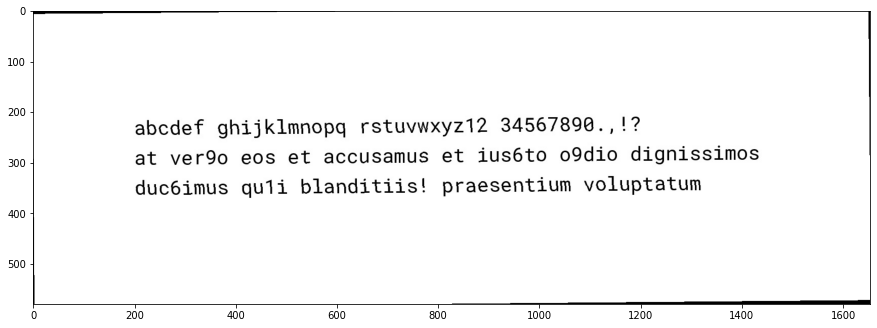

In [135]:
data = inter.rotate(original_image, 0.5, reshape=False, order=0)
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.imshow(data)
plt.show()

3.23